# Make upset plot of MINI-EX regulons cross species

## Import modules

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), 'bin'))
from cross_species_regulon_overlap import * # custom module

import warnings
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from statistics import mean
from upsetplot import plot, from_contents, UpSet

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # suppress performance warnings

## Read in the data

In [2]:
# Define input file locations
file_locs = {"A. thaliana":"input/miniex_regulons/ath_rankedRegulons.csv", "T. aestivum":"input/miniex_regulons/tae_rankedRegulons.csv", "O. sativa":"input/miniex_regulons/osa_rankedRegulons.csv", "Z. mays":"input/miniex_regulons/zma_rankedRegulons.csv"}
correspondance_file = "input/cell_type_correspondance_4_species.csv"
orthology_file = "input/orthogroups.csv"
zma_id_conversion_file = "input/gene_conversion/v4-v5_gene_conversion_zma_plaza.txt"
osa_id_conversion_file = "input/gene_conversion/rice_ID_converter.txt"
ath_alias_info_loc = "input/ath_gene_aliases.tsv"
tae_stability_info_loc = "input/stability_and_specificity_info.csv"

In [3]:
# Define output folder
output_folder = "output"

In [4]:
# Read in orthology info and put in a gene-to-orthogroup dict
orthology_df = pd.read_csv(orthology_file, sep="\t")
gene2group_dict = pd.Series(orthology_df.gf_id.values,index=orthology_df.gene_id).to_dict()

In [5]:
# Load in the maize and rice gene conversion info
zma_gene_old2new, zma_gene_new2old = load_gene_conversion(zma_id_conversion_file)
osa_gene_old2new, osa_gene_new2old = load_gene_conversion(osa_id_conversion_file)

In [6]:
# Read in the input
species2df_dict = read_miniex_files_convert_IDs(file_locs, gene2group_dict, {"Z. mays": zma_gene_old2new, "O. sativa": osa_gene_old2new}, sep=";")

# Arrange the input in a good format
species2gene2group_dict, species2cluster2genes_and_groups = convert_df_to_dict(species2df_dict)

# Read in the cross-species cluster correspondance information
correspondance_dict = get_correspondance_dict(correspondance_file, sep=";")

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2cluster2genes_and_groups, correspondance_dict)

In [7]:
# Read in Ath gene alias info and put in a dict
ath_alias_df = pd.read_csv(ath_alias_info_loc, sep="\t")
gene_to_alias_dict = dict(zip(ath_alias_df["locus_name"], ath_alias_df["symbol"]))
gene_to_alias_dict[""] = "" # map the empty string to an empty string

# Read in the wheat subgenome stability and specificity information
tae_stability_df = pd.read_csv(tae_stability_info_loc, sep=";")
gene_to_stability_dict = dict(zip(tae_stability_df["Gene"], tae_stability_df["Stability"]))
gene_to_specificity_dict = dict(zip(tae_stability_df["Gene"], tae_stability_df["Specificity"]))

## Plot the upsets for each individual tissue

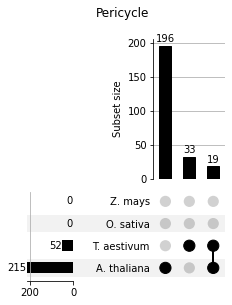

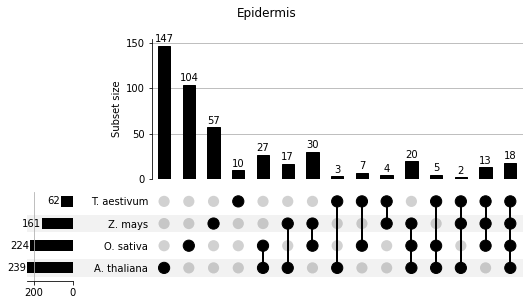

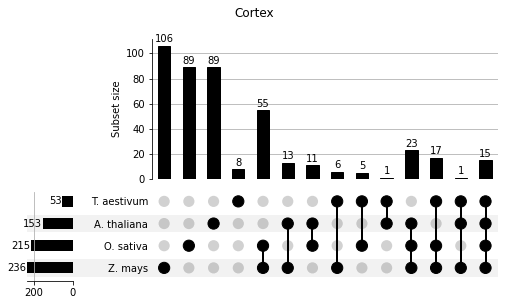

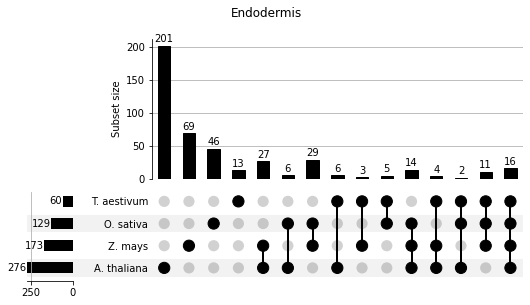

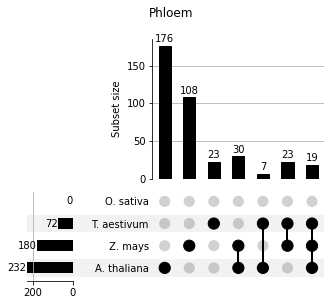

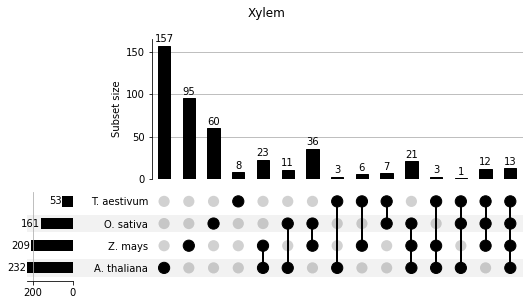

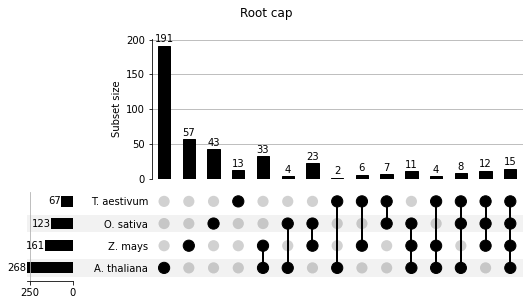

In [8]:
# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

# Generate an upset plot for each tissue
for tissue in tissue_to_upset_input.keys():
    if tissue != "all_tissues":
        plot_result = plot(from_contents(tissue_to_upset_input[tissue]), show_counts=True)
        plot_result["intersections"].set_ylabel("Subset size")
        plt.suptitle("{}".format(tissue))
        plt.savefig("{}/{}_upset_miniex_regulons.svg".format(output_folder, tissue.replace(" ", "-")), format="svg")

## Plot the upsets for each individual tissue (redo with top 50 regulons of each tissue)

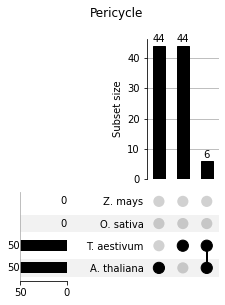

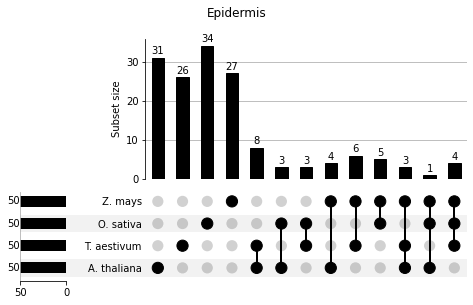

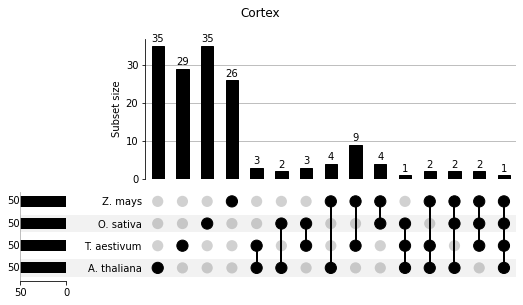

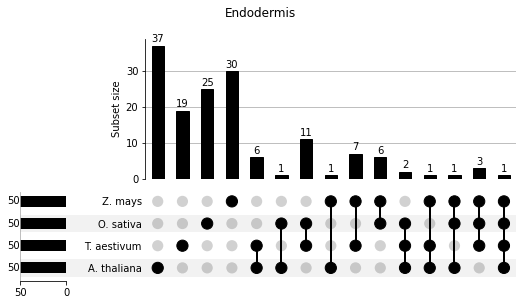

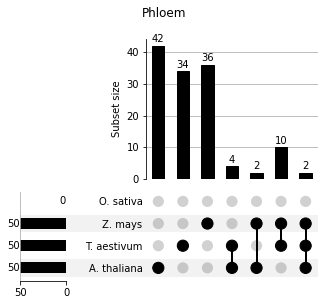

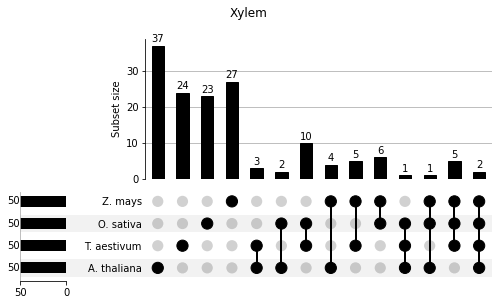

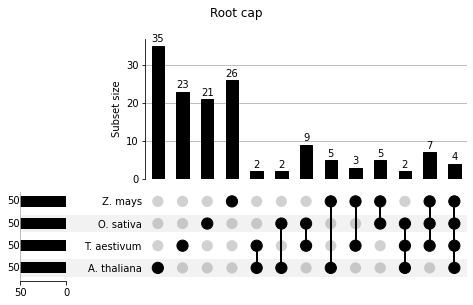

In [9]:
top_N = 50

# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict, top_N)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

# Generate an upset plot for each tissue
for tissue in tissue_to_upset_input.keys():
    if tissue != "all_tissues":
        plot_result = plot(from_contents(tissue_to_upset_input[tissue]), show_counts=True)
        plot_result["intersections"].set_ylabel("Subset size")
        plt.suptitle("{}".format(tissue))
        plt.savefig("{}/{}_upset_miniex_regulons.svg".format(output_folder, tissue.replace(" ", "-")), format="svg")

## Aggregate all tissues together in one plot

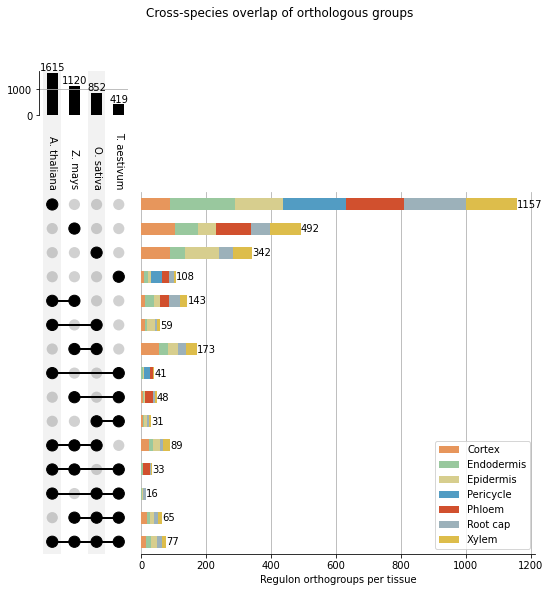

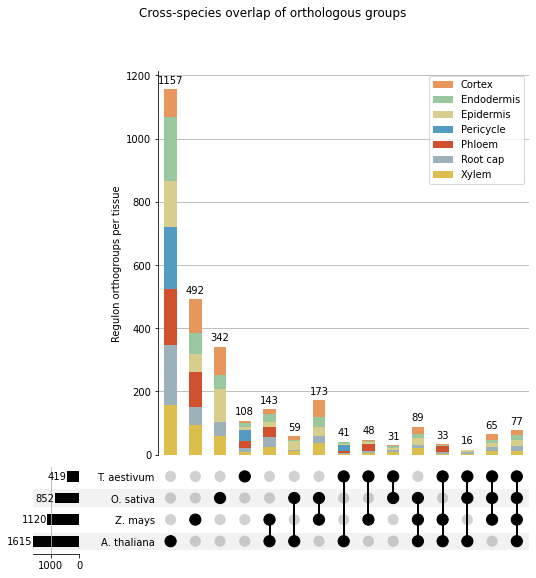

In [10]:
# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

# Get the upset input dataframe for all the tissues combined
upset_input_all = from_contents(tissue_to_upset_input["all_tissues"])

# Add a tissue label to the matrix (for stacked bars)
upset_input_all["tissue"] = upset_input_all.id.str.split("_").str[0]

# Define the colors
tissue_colors = {
    "Endodermis": "#99c89e",
    "Epidermis":  "#d7ce8e",
    "Root cap":   "#9cb1ba",
    "Xylem":      "#ddbd4b",
    "Phloem":     "#d1502e",
    "Cortex":     "#e7965c",
    "Pericycle":  "#529cc3"
}

for orientation in ["vertical", "horizontal"]:
    # Create the upset plot with stacked bars
    upset = UpSet(upset_input_all, show_counts=True, intersection_plot_elements=0, orientation=orientation)  # disable the default bar chart
    upset.add_stacked_bars(by="tissue", colors=tissue_colors, title="Regulon orthogroups per tissue", elements=16)
    upset.plot()
    plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
    plt.savefig("{}/miniex_regulons_upset_{}.svg".format(output_folder, orientation), format="svg")

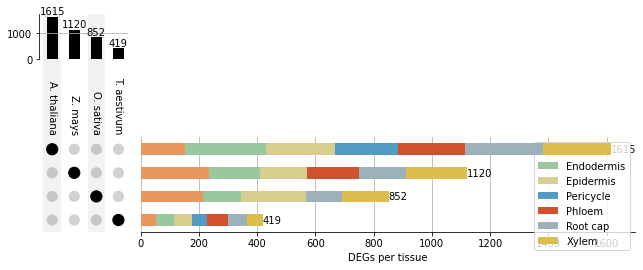

In [11]:
# Add a suffix to make the group IDs species specific (to get colored total species bars)
per_species_groups_dummy = dict()
for species, groups in tissue_to_upset_input["all_tissues"].items():
    per_species_groups_dummy[species] = {group+"_"+species for group in groups}

# Create the corresponding upset input dataframe
upset_input_all_dummy = from_contents(per_species_groups_dummy)

# Add a tissue label to the matrix
upset_input_all_dummy["tissue"] = upset_input_all_dummy.id.str.split("_").str[0]

# Plot vertical in order to take the stacked bars and replace the black bars on the plot above
upset = UpSet(upset_input_all_dummy, show_counts=True, orientation="vertical", intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="tissue", colors=tissue_colors, title="DEGs per tissue", elements=20)
upset.plot()
plt.savefig("{}/miniex_regulons_upset_extra_bars.svg".format(output_folder), format="svg")

## Aggregate all tissues together in one plot (redo with top 50 regulons of each tissue)

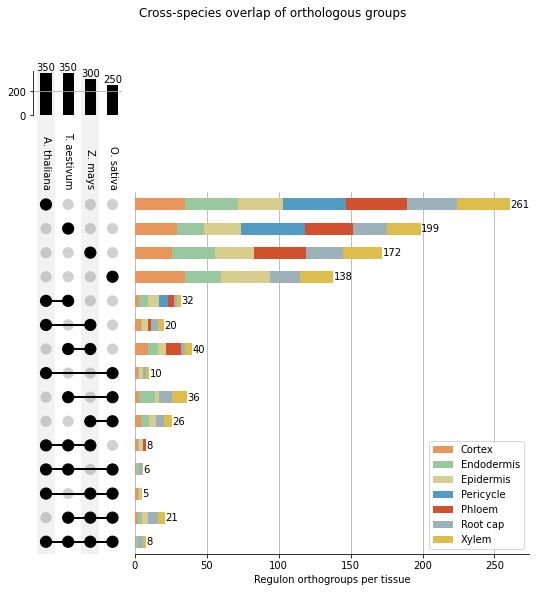

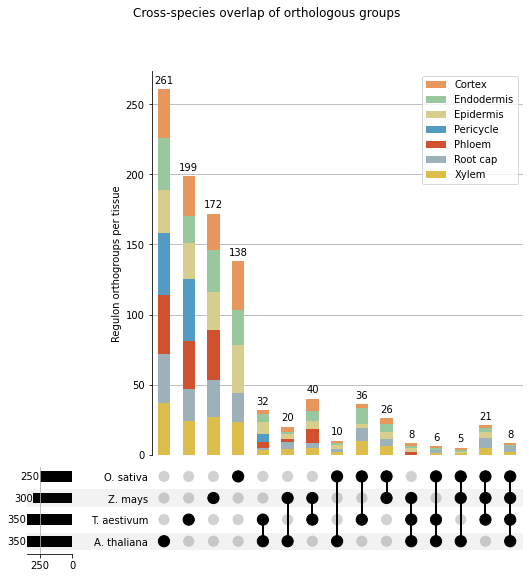

In [12]:
# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict, top_N)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

# Get the upset input dataframe for all the tissues combined
upset_input_all = from_contents(tissue_to_upset_input["all_tissues"])

# Add a tissue label to the matrix (for stacked bars)
upset_input_all["tissue"] = upset_input_all.id.str.split("_").str[0]

# Create the upset plot with stacked bars
for orientation in ["vertical", "horizontal"]:
    upset = UpSet(upset_input_all, show_counts=True, intersection_plot_elements=0, orientation=orientation)  # disable the default bar chart
    upset.add_stacked_bars(by="tissue", colors=tissue_colors, title="Regulon orthogroups per tissue", elements=16)
    upset.plot()
    plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
    plt.savefig("{}/miniex_regulons_upset_top_{}_{}.svg".format(output_folder, top_N, orientation), format="svg")

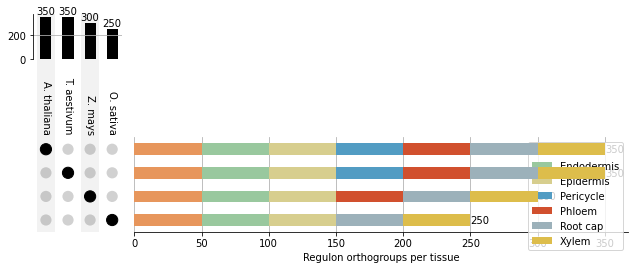

In [13]:
# Add a suffix to make the group IDs species specific (to get colored total species bars)
per_species_groups_dummy = dict()
for species, groups in tissue_to_upset_input["all_tissues"].items():
    per_species_groups_dummy[species] = {group+"_"+species for group in groups}

# Create the corresponding upset input dataframe
upset_input_all_dummy = from_contents(per_species_groups_dummy)

# Add a tissue label to the matrix
upset_input_all_dummy["tissue"] = upset_input_all_dummy.id.str.split("_").str[0]

# Plot vertical in order to take the stacked bars and replace the black bars on the plot above
upset = UpSet(upset_input_all_dummy, show_counts=True, orientation="vertical", intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="tissue", colors=tissue_colors, title="Regulon orthogroups per tissue", elements=20)
upset.plot()
plt.savefig("{}/miniex_regulons_upset_extra_bars_top_{}.svg".format(output_folder, top_N), format="svg")

## Plot overall conservation per tissue

### Prepare date for a conservation bar plot

In [14]:
# Initialize dataframe (similar to the upset input dataframe) including all tissues
upset_input_all = None

# Create input dataframes for each tissue
for tissue in tissue_to_upset_input.keys():
    
    # Get the upset input dataframe (to modify for the barplot)
    if tissue == "all_tissues":
        pass
    else:
        upset_input = from_contents(tissue_to_upset_input[tissue])
        
        # Add conservation (conserved in n species) as an integer under lowercase "conservation"
        upset_input["conservation"] = [sum(is_conserved) for is_conserved in list(upset_input.index)]
        
        # Add Conservation as a string under uppercase "Conservation"
        upset_input["Conservation"] = ["in {} species".format(sum(is_conserved)) for is_conserved in list(upset_input.index)]
        
        # Add tissue as column
        upset_input["Tissue"] = tissue
        
        # Concatenate the dataframes of all tissues into one
        if upset_input_all is None:
            upset_input_all = upset_input
        else:
            upset_input_all = pd.concat([upset_input_all, upset_input])

### Plot conservation bar plot

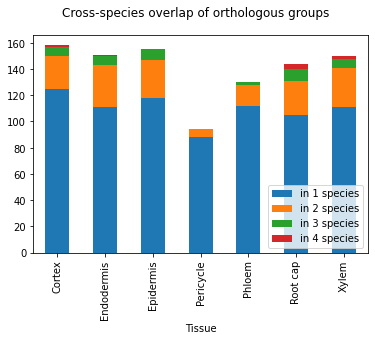

In [15]:
upset_input_all.groupby(["Tissue", "Conservation"]).size().unstack(fill_value=0).plot.bar(stacked=True)
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.legend(loc="lower right")
plt.savefig("{}/miniex_regulons_per_tissue_barplot.svg".format(output_folder), format="svg")

### Plot conservation bar plot (only 2-4 species conservation)

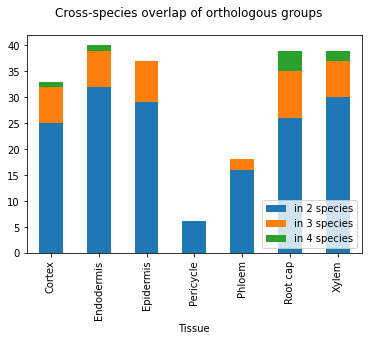

In [16]:
upset_input_all.query("conservation > 1").groupby(["Tissue", "Conservation"]).size().unstack(fill_value=0).plot.bar(stacked=True)
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.legend(loc="lower right")
plt.savefig("{}/miniex_regulons_per_tissue_barplot_min_2_species.svg".format(output_folder), format="svg")

### Plot conservation bar plot (only 3-4 species conservation)

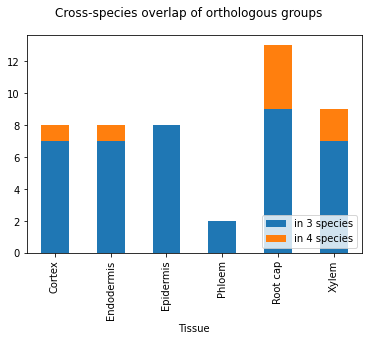

In [17]:
upset_input_all.query("conservation > 2").groupby(["Tissue", "Conservation"]).size().unstack(fill_value=0).plot.bar(stacked=True)
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.legend(loc="lower right")
plt.savefig("{}/miniex_regulons_per_tissue_barplot_min_3_species.svg".format(output_folder), format="svg")

## Write the underlying gene IDs to an Excel file

In [18]:
# Reverse the gene-to-group dict into a group-to-genes dict
species2group2genes_dict = reverse_gene_to_group_dict(species2gene2group_dict)

# Combine the clusters of the same tissue
species2tissue2genes_and_groups = convert_to_tissues(species2cluster2genes_and_groups, correspondance_dict)

# Create the base dataframe with on each row a combination of species for a given tissue
upset_input = from_contents(tissue_to_upset_input["all_tissues"])
species_combination_df = pd.DataFrame(upset_input.index.unique().tolist(), columns=upset_input.index.names)
species_combination_df = species_combination_df.merge(pd.DataFrame(upset_input_all.Tissue.unique(), columns=["Tissue"]), how="cross")

In [19]:
with pd.ExcelWriter("{}/miniex_regulons_overlap_gene_IDs.xlsx".format(output_folder), engine="xlsxwriter") as writer:
    
    for species in species_combination_df.columns[:-1]: # the last column is the tissue
        
        # Initialize a dataframe to extend with the genes of a given species, using the base dataframe defined above
        species_combination_df_copy = species_combination_df.copy()
        
        # Initialize lists to store genes and orthogroups, to be added as columns
        genes_col = list()
        groups_col = list()
        
        # Loop over each species and tissue combination
        for i in species_combination_df_copy.index:
            
            # If the current species is included in the combination of species in this row
            if species_combination_df_copy.loc[i,species] == True:
                
                # Get the binary tuple of which species are present in the current row
                species_tuple = tuple(species_combination_df_copy.iloc[i,:-1])
                
                # Get the tissue of the current row
                tissue = species_combination_df_copy.iloc[i,-1]
                
                # Use the binary tuple as key to get the groups of a specific species combination, for a given tissue
                groups = set(upset_input_all.loc[species_tuple,:].query("Tissue == @tissue").id.str.split("_").str[1])

                # Convert groups into genes
                genes = set()
                for group in groups:
                    genes.update(species2group2genes_dict[species][group])
                    
                # Retain only genes that were in the original DEGs for that tissue
                genes = genes & species2tissue2genes_and_groups[species][tissue]["genes"]

                gene_list, group_list = list(genes), list(groups)

            else:
                gene_list, group_list = [""], [""]
            
            # Sort the genes and orthogroups alphabetically and combine them into a string
            gene_list.sort()
            group_list.sort()
            genes_col.append(", ".join(gene_list))
            groups_col.append(", ".join(group_list))
        
        # Add the genes and orthogroups as a column in the dataframe
        species_combination_df_copy["Genes"] = genes_col
        species_combination_df_copy["Orthogroups"] = groups_col
        
        # Write the final dataframe into an excel file, in a tab with the species name
        species_combination_df_copy.to_excel(writer, sheet_name=species, index=False)

### Example dataframe (in one Excel tab)

In [20]:
species_combination_df_copy

,A. thaliana,T. aestivum,O. sativa,Z. mays,Tissue,Genes,Orthogroups
0,True,False,False,False,Pericycle,,
1,True,False,False,False,Epidermis,,
2,True,False,False,False,Cortex,,
3,True,False,False,False,Endodermis,,
4,True,False,False,False,Phloem,,
...,...,...,...,...,...,...,...
100,False,False,False,True,Cortex,"Zm00001eb006200, Zm00001eb012310, Zm00001eb032...","ORTHO905GF001174, ORTHO905GF001266, ORTHO905GF..."
101,False,False,False,True,Endodermis,"Zm00001eb002010, Zm00001eb009550, Zm00001eb015...","ORTHO905GF000281, ORTHO905GF000501, ORTHO905GF..."
102,False,False,False,True,Phloem,"Zm00001eb006160, Zm00001eb015150, Zm00001eb015...","ORTHO905GF000437, ORTHO905GF000622, ORTHO905GF..."
103,False,False,False,True,Xylem,"Zm00001eb000690, Zm00001eb009550, Zm00001eb036...","ORTHO905GF000206, ORTHO905GF000281, ORTHO905GF..."


### Read in the ranked regulon file for each species because we need the ranking

In [21]:
# Read in the input
species2df_dict = read_miniex_files_convert_IDs(file_locs, gene2group_dict, {"Z. mays": zma_gene_old2new, "O. sativa": osa_gene_old2new}, sep=";")

# Get the top N orthogroup dataframes per tissue and species, with rank info
tissue_to_species_to_ranked_df = extract_ranked_orthogroups(species2df_dict, correspondance_dict, top_N=top_N)

### Gather DEG information

In [22]:
# Define input file locations
file_locs = {"A. thaliana":"input/markers/ath_log2FC0.5_FDR0.05.csv",\
             "T. aestivum":"input/markers/tae_log2FC0.5_FDR0.05.csv",\
             "O. sativa":"input/markers/osa_log2FC0.5_FDR0.05.csv", \
             "Z. mays":"input/markers/zma_log2FC0.5_FDR0.05.csv"}

# Read in the input
species2df_dict = read_files(file_locs, sep=",")

# Arrange the input in a good format
species2tissue2genes_and_groups_strong_de = extract_genes_and_orthogroups_degs(species2df_dict, correspondance_dict, top_N=np.Inf)

In [23]:
# Define input file locations
file_locs = {"A. thaliana":"input/markers/ath_log2FC0.25_FDR0.05.csv",\
             "T. aestivum":"input/markers/tae_log2FC0.25_FDR0.05.csv",\
             "O. sativa":"input/markers/osa_log2FC0.25_FDR0.05.csv", \
             "Z. mays":"input/markers/zma_log2FC0.25_FDR0.05.csv"}

# Read in the input
species2df_dict = read_files(file_locs, sep=",")

# Arrange the input in a good format
species2tissue2genes_and_groups_weak_de = extract_genes_and_orthogroups_degs(species2df_dict, correspondance_dict, top_N=np.Inf)

### Format the output dataframe (rearrange and rename columns)

In [24]:
marker_ranking_df = upset_input_all.reset_index()
marker_ranking_df["Orthogroup"] = marker_ranking_df.id.str.split("_").str[-1]
marker_ranking_df = marker_ranking_df.drop(columns=["id", "Conservation"])
marker_ranking_df["Conservation"] = marker_ranking_df["conservation"]
marker_ranking_df = marker_ranking_df.drop(columns=["conservation"])
marker_ranking_df = marker_ranking_df.rename(columns={"Tissue": "Cell type"})

### Calculate an aggregate score within each orthogroup and add to the dataframe

In [25]:
def get_de_state(gene, species, tissue, species2tissue2genes_and_groups_strong_de, species2tissue2genes_and_groups_weak_de):
    if gene in species2tissue2genes_and_groups_strong_de[species][tissue]["genes"]:
        return "S"
    elif gene in species2tissue2genes_and_groups_weak_de[species][tissue]["genes"]:
        return "W"
    else:
        return "N"

In [26]:
# Initialize dictionaries to store the best marker genes and other marker genes for each species
species_to_best_marker = {species: list() for species in species2tissue2genes_and_groups.keys()}
species_to_other_markers = {species: list() for species in species2tissue2genes_and_groups.keys()}

# Initialize dictionaries to store the DE state of the best marker genes and other marker genes for each species
species_to_best_marker_de_state = {species: list() for species in species2tissue2genes_and_groups.keys()}
species_to_other_markers_de_state = {species: list() for species in species2tissue2genes_and_groups.keys()}

# Initialize a list to store the mean of species ranks for each marker
mean_species_ranks = list()

# Loop over each (tissue-specific) marker orthogroup in the marker ranking dataframe
for i in marker_ranking_df.index:
    
    # Get the tissue and orthogroup for the current marker
    tissue = marker_ranking_df.loc[i,"Cell type"]
    group = marker_ranking_df.loc[i,"Orthogroup"]
    
    # Initialize a list to store the best ranks for the current marker across species
    best_ranks_per_species = list()
    
    # Loop over each species
    for species in species2tissue2genes_and_groups.keys():
        
        # If the current species is included in the combination of species in this row
        if marker_ranking_df.loc[i,species] == True:
            
            # Identify genes belonging to the current orthogroup and tissue, for the given species
            genes = species2group2genes_dict[species][group] & species2tissue2genes_and_groups[species][tissue]["genes"]
            
            # Get the dataframe of ranked genes for the current tissue and species
            df = tissue_to_species_to_ranked_df[tissue][species]
            
            # Filter the dataframe to include only the identified genes
            filtered_df = df[df["gene ID"].isin(genes)]
            
            # Find the gene with the best rank
            i_best = filtered_df["Rank"].idxmin()
            best_marker_gene = filtered_df.loc[i_best, "gene ID"]
            
            # Get the DE state of the best gene
            best_de_state = get_de_state(best_marker_gene, species, tissue, \
                                         species2tissue2genes_and_groups_strong_de, \
                                         species2tissue2genes_and_groups_weak_de)
            
            # Get the list of other marker genes sorted by rank, and convert to string
            other_marker_genes = list(filtered_df.sort_values(by="Rank", ascending=True)["gene ID"].astype(str))
            other_de_states = [\
                               get_de_state(other_marker_gene, species, tissue, \
                                            species2tissue2genes_and_groups_strong_de, \
                                            species2tissue2genes_and_groups_weak_de) \
                               for other_marker_gene in other_marker_genes \
                              ]
            other_marker_genes = ""+(", ".join(other_marker_genes[1:]))
            other_de_states = ""+(", ".join(other_de_states[1:]))
            
            # Get the best rank for the gene
            best_rank = filtered_df.loc[i_best, "Rank"]
            
            # Append the best rank to the list of best ranks for the current marker
            best_ranks_per_species.append(best_rank)
            
        else:
            best_marker_gene, other_marker_genes = "", ""
            best_de_state, other_de_states = "", ""
        
        # Add the best marker gene and other marker genes to their respective dictionaries
        species_to_best_marker[species].append(best_marker_gene)
        species_to_other_markers[species].append(other_marker_genes)
        
        # Add the DE state of the best marker gene and other marker genes to their respective dictionaries
        species_to_best_marker_de_state[species].append(best_de_state)
        species_to_other_markers_de_state[species].append(other_de_states)
    
    # Calculate the mean of the best ranks for the current marker across species
    mean_species_ranks.append(mean(best_ranks_per_species))

# Add the mean ranks to the marker ranking dataframe as a new column "Score"
marker_ranking_df["Score"] = mean_species_ranks

# Add the Arabidopsis gene aliases
marker_ranking_df["Ath best marker alias"] = [gene_to_alias_dict[marker] if marker in gene_to_alias_dict else marker for marker in species_to_best_marker["A. thaliana"]]

# Add the wheat subgenome stability
marker_ranking_df["Wheat subgenome stability"] = [gene_to_stability_dict[marker] if marker in gene_to_stability_dict else "" for marker in species_to_best_marker["T. aestivum"]]

# Add the wheat subgenome specificity
marker_ranking_df["Wheat subgenome specificity"] = [gene_to_specificity_dict[marker] if marker in gene_to_specificity_dict else "" for marker in species_to_best_marker["T. aestivum"]]

### Add final ranking to the dataframe and write results to Excel file

In [27]:
with pd.ExcelWriter("{}/reprocessed_cross_species_markers.xlsx".format(output_folder), engine='xlsxwriter') as writer:
    
    for species in species2tissue2genes_and_groups.keys():
        
        # Initialize a dataframe to extend with the genes of a given species, using the base dataframe defined above
        marker_ranking_df_copy = marker_ranking_df.copy()
        
        # Add the best marker and all the other markers for one orthogroup as two columns in the dataframe
        marker_ranking_df_copy["Best marker"] = species_to_best_marker[species]
        marker_ranking_df_copy["Other markers"] = species_to_other_markers[species]
        
        # Add the DE state of the best marker and all the other markers for one orthogroup as two columns in the dataframe
        marker_ranking_df_copy["DE state best marker"] = species_to_best_marker_de_state[species]
        marker_ranking_df_copy["DE state other markers"] = species_to_other_markers_de_state[species]
        
        # Sort the marker orthogroups on the score
        marker_ranking_df_copy = marker_ranking_df_copy.sort_values(by=["Conservation", "Score"], ascending=[False, True])

        # Convert scores to ranks
        marker_ranking_df_copy["Score"] = range(1,marker_ranking_df_copy.shape[0]+1)
        marker_ranking_df_copy = marker_ranking_df_copy.rename(columns={"Score": "Rank"})
        
        # Write the final dataframe into an excel file, in a tab with the species name
        marker_ranking_df_copy.to_excel(writer, sheet_name=species, index=False)